# Golgi cell rendering

This notebook contains:
- Functions to look at and visualize the Golgi cell data produced by BREP
- Functions that generate and store Golgi cell data similar to the BREP data.


In [1]:
import os
import csv
import numpy as np
from collections import OrderedDict
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline


In [2]:
# Utils
res_p = os.getcwd()+'/output_1/'

fns = OrderedDict ()
fns['aa_gol_dist']='AAtoGoCdistances.dat'
fns['aa_gol_segs']='AAtoGoCsegments.dat'
fns['aa_gol_source']='AAtoGoCsources.dat'
fns['aa_gol_target']='AAtoGoCtargets.dat'

fns['gran_coord'] ='GCcoordinates.sorted.dat'       
fns['gran_t_coord']='GCTcoordinates.sorted.dat'
    
fns['go_coord']='GoCcoordinates.sorted.dat'
fns['go_basd_coord']='GoCbdendcoordinates.sorted.dat'
fns['go_apical_coord']='GoCadendcoordinates.sorted.dat'
fns['go_axon_coord']='GoCaxoncoordinates.sorted.dat'
fns['go_dist']='GoCdistances.dat' #
       
fns['go_go_dist']='GoCtoGoCdistances.dat'
fns['go_go_sources']='GoCtoGoCsources.dat'
fns['go_go_targets']='GoCtoGoCtargets.dat'
fns['go_go_gap_dist']='GoCtoGoCgapdistances.dat'
fns['go_go_gap_source']='GoCtoGoCgapsources.dat'
fns['go_go_gap_target']='GoCtoGoCgaptargets.dat'

fns['pf_go_dist']='PFtoGoCdistances.dat'
fns['pf_go_seg']='PFtoGoCsegments.dat'
fns['pf_go_source']='PFtoGoCsources.dat'
fns['pf_go_target']='PFtoGoCtargets.dat'

def read_in_coordfile (fn, parse_ignore = True):
    '''
    reads in the file stored under fn (works for certain files that contain coordinates)
    Returns a np array with the data.
    If there is a problem parsing, this function will not break, however it will store it in a dict 
    If parse-ignore is set False, the number of unparsable signs as well as a set of them will be printed.
    '''
    res = []
    with open (fn, newline = '') as f:
        rr = csv.reader(f, delimiter = ' ')
        err = []
        for line in rr:
            ar = []
            for j in range(len(line)):
                try: ar.append(float(line[j]))
                except: err.append(line[j])
            res.append(np.asarray(ar))
    if len(err)> 0 and not parse_ignore: print ('Could not parse on {} instances: {}'.format(len(err), set(err)))
    return np.asarray(res)

def gen_dendrites (som, c_r, c_h, c_m, c_std, c_sp, col = 'kx', plot_fig = False):
    '''Generates dendrites as described in the paper:
    som = coordinates of somata
    c_r = maximal radius of cone
    c_h = height of cone
    c_m = mean angle for each dendrite (number of elements = number of dendrites per cell)
    c_std = standard deviation (degree) for the angle of the dendrite
    c_sp = spacing between the points
    col = color if plot function is enabled
    plot_fig = plot the results?
    Returns a list of lists containing arrays with the coordinates of the dendrites
    '''
    c_n = int(np.linalg.norm([c_r, c_h])/c_sp) #number of points per dendrite
    c_gr = np.linspace(0,1,c_n)*np.ones((3, c_n)) #linspace grid between 0 and 1 with c_n elements
    b_res = []
    for i in range(len(som)): #each cell
        som_c = som[i,:]
        d_res = []
        for cc_m in c_m: #each dendrite
            ep_ang = (np.random.randn()*c_std + cc_m)*np.pi/180 #angle
            pt = ([np.sin(ep_ang)*c_r, np.cos(ep_ang)*c_r, c_h])*c_gr.T #coordinates of the dendrite = endpoint*grid 
            if plot_fig: ax.plot(pt[:,0], pt[:,1], pt[:,2], col);
            d_res.append(pt+som_c) 
        b_res.append(d_res)
    return b_res

def dend_to_file_format (dend):
    '''change format of the lists from the gen_dendrites funnction so that they can be stored in the same way as 
    the BREP data'''
    dd = np.asarray([np.ravel(np.concatenate((dend[i][0], dend[i][1]))) for i in range(len(dend))])
    return dd

def generate_axon (coord, ax_x, ax_y, ax_z, n_pts):
    '''
    Generates axons represented by uniformly distributed points.
    Soma is included as one of the points
    ax_x,y,z: limits in transverse, sagittal and vertical direction
    n_pts: number of points
    returns them in array shape.
    '''
    res = []
    for j in range(len(coord)):
        ar = np.random.uniform(size = [n_pts, 3])
        for i, [low, high] in enumerate([ax_x, ax_y, ax_z]):
            ar[:,i] = ar[:,i]*(high-low)+low+coord[j,i]
        ar[0,:] = (coord[j,:]) # include point of soma (as done in the original BREP)
        res.append(ar.ravel())
    return np.asarray(res)

def coord_reshape (dat):
    ''' reshapes the result of the read_in_coordfile function so that it can be plotted and processes more easily
    '''
    dat = dat.reshape([dat.shape[0], int(dat.shape[1]/3),3])
    return dat


## Rendering the Golgi cell dendrites

In [3]:
a_h = 332.0
a_r= 100.0
b_h = -6.0
b_r = 60.0
a_m = [30.0, 120.0]
b_m = [-20.0, -240.0]
b_std = 6.6
a_std = 14.4
a_sp = 7.5
b_sp = 7.5


coord = read_in_coordfile(res_p +fns['go_coord']) #soma points

a_dend = gen_dendrites(coord, a_r, a_h, a_m, a_std, a_sp, 'gx')
b_dend = gen_dendrites(coord, b_r, b_h, b_m, b_std, b_sp, 'kx')

af = (dend_to_file_format(a_dend))
np.savetxt('new_apical.dat', af, delimiter=' ')

bf = (dend_to_file_format(b_dend))
np.savetxt('new_basal.dat', bf, delimiter=' ')

## Rendering the Golgi cell axons

In [4]:
ax_x = [-45, 45] #transverse
ax_y = [-160, 160] #sagittal
ax_z = [-75, 75] #vertical
n_pts = 40

coord = read_in_coordfile(res_p +fns['go_coord']) #soma points

my_ax = generate_axon (coord, ax_x, ax_y, ax_z, n_pts)

np.savetxt('new_axon.dat', my_ax , delimiter=' ')

## Plotting the old and new Golgi cell dendrites and axons

In [5]:
#read in
coord = read_in_coordfile(res_p +'/'+fns['go_coord'])
apical = read_in_coordfile(res_p +'/'+fns['go_apical_coord'])
basal = read_in_coordfile(res_p +'/'+fns['go_basd_coord'])
axon = read_in_coordfile(res_p +'/'+fns['go_axon_coord'])
new_ap = read_in_coordfile('new_apical.dat', parse_ignore=False)
new_bas = read_in_coordfile('new_basal.dat', parse_ignore=False)
new_ax = read_in_coordfile('new_axon.dat', parse_ignore=False)

#reshape
apical = apical.reshape([apical.shape[0],int(apical.shape[1]/3),3])
basal = basal.reshape([basal.shape[0],int(basal.shape[1]/3),3])
axon = axon.reshape([axon.shape[0],int(axon.shape[1]/3),3])
new_ap = coord_reshape(new_ap)
new_bas = coord_reshape(new_bas)
new_ax = coord_reshape(new_ax)

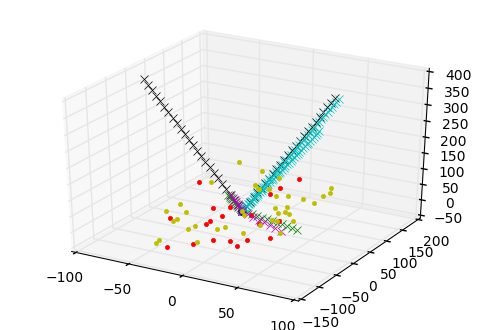

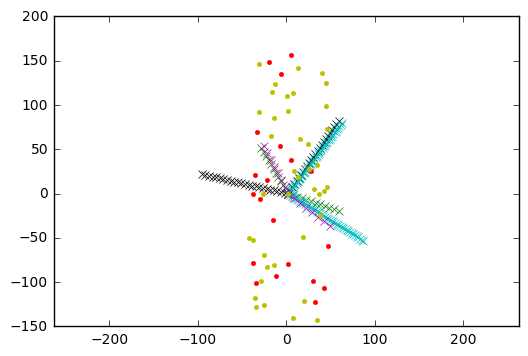

In [6]:
# plot
ns = np.arange(1) #neurons to be plotted.

plot_somata = True
plot_apical = 1
plot_basal = 1
plot_axon = 1
plot_new_ap = 1
plot_new_bas  = 1
plot_new_ax = 1
overlay = 0

options= [
    (apical, plot_apical, 'kx'),
    (basal, plot_basal, 'gx'), 
    (axon, plot_axon, 'r.'), 
    (new_ap, plot_new_ap, 'cx'),
    (new_bas, plot_new_bas, 'mx'),
    (new_ax, plot_new_ax, 'y.')]


fig = plt.figure()
ax = fig.gca(projection='3d')
if plot_somata: 
    if not overlay: ax.plot(coord[ns,0], coord[ns,1], coord[ns,2], 'bo')
    else: ax.plot ([0],[0],[0],'bo')

#plot dendrites and axon.
for pts, yn, col in options:
    for i in ns:
        if yn:
            if overlay: pt = pts[i,:,:]-coord[i,:]
            else: pt = pts[i,:,:]
            ax.plot(pt[:,0], pt[:,1], pt[:,2], col)

#ax.view_init(30,180)
proj2D = True
if proj2D:
    plt.figure()
    for pts, yn, col in options:
        for i in ns:
            if yn:
                if overlay: pt = pts[i,:,:]-coord[i,:]
                else: pt = pts[i,:,:]
                plt.plot(pt[:,0], pt[:,1], col)
                plt.axis('equal')